# PCQC Kruskal- choose specific parameters for clustering.  Doesn't make sense to test over all parameters.  

### Bigger Problem with Kruskal: Biased for large clusters- hard to interpret p-values

### Conclusions
1. Got 18 significant for permutation test (not 100).

In [1]:
import sys
sys.path.append('../pcqc')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pcqc import *

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
output_plots = 'pbmc_plots/cluster_performance_pt4.pdf'
plot_dictionary = dict()

In [3]:
import scanpy as sc

In [4]:
from sklearn.naive_bayes import MultinomialNB

In [5]:
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, log_loss, confusion_matrix
from sklearn.metrics import average_precision_score, recall_score

In [6]:
from matplotlib.backends.backend_pdf import PdfPages

### Get Data

In [7]:
sim_data = pd.read_csv('data/pbmc_original_data.csv')

In [8]:
data = sim_data.iloc[:,1:1839]

In [9]:
y_names = sim_data['truth_names']

In [10]:
y = sim_data['reduced_clustering'].astype(int)

In [11]:
y

0        0
1        2
2        2
3        1
4        3
        ..
2633     7
2634     2
2635     5
2636     5
2637    10
Name: reduced_clustering, Length: 2638, dtype: int64

In [12]:
ground_truth = pd.DataFrame(y_names.values, columns = ['leiden'])

In [13]:
ground_truth.shape

(2638, 1)

In [14]:
ground_truth

,leiden
0,CD8
1,CD4 T
2,CD4 T
3,CD14+
4,NK
...,...
2633,Dendritic
2634,CD4 T
2635,B Cells
2636,B Cells


In [15]:
sim_data.columns

Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '1830', '1831', '1832', '1833', '1834', '1835', '1836', '1837',
       'reduced_clustering', 'truth_names'],
      dtype='object', length=1841)

In [16]:
ground_truth['count'] = 1

In [17]:
ground_truth.shape

(2638, 2)

In [18]:
data.shape

(2638, 1838)

### Define Functions

In [19]:
def data_sim(adata, sim_name, df_stats, ground_truth, res_params = np.arange(.4,2,.4), 
             n_neighbor_params = np.arange(10,30,5), trials = 20, random_state_start = 0, save = False,
            n_pcs = None, use_rep = None, save_directory = ''):
    random_state = random_state_start
    index = df_stats.shape[0]
    y = ground_truth['leiden']
    unique_values = np.unique(y)
    weights = ground_truth.groupby('leiden')['count'].transform(lambda x: 1/x.count()).values
    #create new directory to save results
    directory = save_directory + '/' + sim_name
    if save:
        os.mkdir(directory)
        
    for n_neighbors in n_neighbor_params:
        sc.pp.neighbors(adata,n_neighbors = n_neighbors, use_rep = use_rep, n_pcs = n_pcs)
        for res_param in res_params:
            for trial in range(trials):
                print('Trial: ' + str(np.round(trial,2)) + ' Res: ' + str(np.round(res_param,2)) + ' Nbrs: ' + str(np.round(n_neighbors,2)) + '   ', 
                      end = '\r')
                #compute simulation with metrics
                sc.tl.leiden(adata, resolution = res_param, random_state = random_state)
                X = pd.get_dummies(adata.obs['leiden'])
                predictions, metrics = compute_model_loss(X,y,weights)
                submetrics = compute_log_loss_by_class(predictions,y)
                new_row = [sim_name, trial, res_param, n_neighbors, 
                                       metrics['log_loss'], metrics['average_precision_score'],
                                      metrics['weighted_accuracy']] + submetrics
                
                df_stats.loc[index] = new_row
                
                #if we want to save the predictions
                if save:
                    file_location = directory + '/' + 'res_' + str(res_param) + 'n_nbrs_' + str(n_neighbors) \
                                + 'trial_' + str(trial) + '.npy'
                    np.save(file_location,predictions)
                    
                index += 1
                random_state += 1
    return df_stats

In [20]:
def compute_log_loss_by_class(predictions,y):
    output = []
    unique_values = np.unique(y)
    for response in unique_values:
        filtered_rows = np.where(y == response)[0]
        subset_log_loss = log_loss(y[filtered_rows], predictions[filtered_rows,:], labels = unique_values)
        output.append(subset_log_loss)
    return output

In [21]:
def compute_model_loss(X,y,weights):
    dummies_y = pd.get_dummies(y).values
    Bayes = MultinomialNB(fit_prior = False)
    Bayes.fit(X,y)
    predictions = Bayes.predict_proba(X)
    loglo = log_loss(y, predictions, sample_weight = weights)
    aps = average_precision_score(dummies_y, predictions, average = 'macro')
    weighted_accuracy = Bayes.score(X,y,sample_weight = weights)
    metrics = {'log_loss':loglo,'average_precision_score': aps,
               'weighted_accuracy':weighted_accuracy}
    return predictions, metrics

In [22]:
def prob_confusion_matrix(probs,ground_truth):
    #probabilistic confusion matrix that enforces balanced class sizes
    df = pd.DataFrame(probs)
    df['clusters'] = ground_truth
    confusion_matrix = df.groupby('clusters').mean()
    return confusion_matrix

### First Try Traditional PCA/PC Permutation

In [23]:
adata = sc.AnnData(X = data.values)
sc.tl.pca(adata,n_comps = 100)

In [24]:
columns = ['name', 'trial', 'resolution', 'n_neighbors', 'log_loss','aps','weighted_accuracy']
for value in np.unique(ground_truth['leiden']):
    columns.append('log_loss_cluster_' + str(value))

df_stats = pd.DataFrame(columns = columns)

In [25]:
#start with simple PCA, the 7/8 selection is also consistent with Kruskal (using all 100 PCs)
for n_pcs in [6,7]:
    if n_pcs in [6]:
        string = 'PC_Scree_' + str(n_pcs)
    else:
        string = 'PC_Scree/Perm_' + str(n_pcs)
    df_stats = data_sim(adata, string, df_stats, ground_truth, random_state_start = 0, n_pcs = n_pcs)

In [26]:
for n_pcs in [25,50,100]:
    string = 'PCs_' + str(n_pcs)
    df_stats = data_sim(adata, string, df_stats, ground_truth, random_state_start = 0, n_pcs = n_pcs)

In [27]:
#struggles to differentiate CD4/8/Others
df_stats.groupby('name').median()

,resolution,log_loss,aps,weighted_accuracy,log_loss_cluster_B Cells,log_loss_cluster_CD14+,log_loss_cluster_CD4 T,log_loss_cluster_CD8,log_loss_cluster_Dendritic,log_loss_cluster_FCGR3A Monocytes,log_loss_cluster_Megakaryocytes,log_loss_cluster_NK,log_loss_cluster_Other
name,,,,,,,,,,,,,
PC_Scree/Perm_7,1.0,0.910985,0.590633,0.690204,0.554241,0.766323,1.371908,1.352762,1.302374,0.382149,0.440677,0.530151,1.522491
PC_Scree_6,1.0,0.906254,0.597558,0.690732,0.561239,0.782916,1.365629,1.378319,1.244619,0.389172,0.431882,0.514136,1.504682
PCs_100,1.0,1.063490,0.480491,0.571036,0.600761,1.023959,1.409359,1.589818,1.336994,0.895936,0.512077,0.669307,1.575820
PCs_25,1.0,0.858901,0.601127,0.706400,0.564085,0.710924,1.366199,1.330404,1.250929,0.447900,0.083843,0.485616,1.495066
PCs_50,1.0,1.038725,0.479605,0.575026,0.592433,0.773710,1.364402,1.550914,1.288122,0.906195,0.432599,0.654590,1.524365


### Then try PCQC

In [28]:
#try top 15,20
pca = PC_Cluster(n_pcs = 100)
pca.fit(data.values)
pca.pc_distribution()
pca.pc_stats(thresholds=[0.9,0.95,0.98,0.99,0.995])
pca.select_top_pcs(criteria = '100.0_Percentile', n_top_pcs = 11)
reduced_matrix = pca.use_top_pcs()
adata_pcqc = sc.AnnData(X = reduced_matrix)

In [29]:
df_stats = data_sim(adata_pcqc, 'PCQC_99.5_11Pcs', df_stats, ground_truth, 
                    random_state_start = 0, n_pcs = 0, use_rep = 'X')

In [30]:
df_stats.groupby('name').median()

,resolution,log_loss,aps,weighted_accuracy,log_loss_cluster_B Cells,log_loss_cluster_CD14+,log_loss_cluster_CD4 T,log_loss_cluster_CD8,log_loss_cluster_Dendritic,log_loss_cluster_FCGR3A Monocytes,log_loss_cluster_Megakaryocytes,log_loss_cluster_NK,log_loss_cluster_Other
name,,,,,,,,,,,,,
PCQC_99.5_11Pcs,1.0,0.883700,0.603260,0.704091,0.557561,0.723942,1.348063,1.340246,1.242055,0.431862,0.380968,0.470969,1.498599
PC_Scree/Perm_7,1.0,0.910985,0.590633,0.690204,0.554241,0.766323,1.371908,1.352762,1.302374,0.382149,0.440677,0.530151,1.522491
PC_Scree_6,1.0,0.906254,0.597558,0.690732,0.561239,0.782916,1.365629,1.378319,1.244619,0.389172,0.431882,0.514136,1.504682
PCs_100,1.0,1.063490,0.480491,0.571036,0.600761,1.023959,1.409359,1.589818,1.336994,0.895936,0.512077,0.669307,1.575820
PCs_25,1.0,0.858901,0.601127,0.706400,0.564085,0.710924,1.366199,1.330404,1.250929,0.447900,0.083843,0.485616,1.495066
PCs_50,1.0,1.038725,0.479605,0.575026,0.592433,0.773710,1.364402,1.550914,1.288122,0.906195,0.432599,0.654590,1.524365


In [31]:
pca.select_top_pcs(criteria = '98.0_Percentile', n_top_pcs = 8)
reduced_matrix = pca.use_top_pcs()
adata_pcqc = sc.AnnData(X = reduced_matrix)

In [32]:
df_stats = data_sim(adata_pcqc, 'PCQC_98P_8PCs', df_stats, ground_truth, 
                    random_state_start = 0, n_pcs = 0, use_rep = 'X')

In [33]:
df_stats.groupby('name').median()

,resolution,log_loss,aps,weighted_accuracy,log_loss_cluster_B Cells,log_loss_cluster_CD14+,log_loss_cluster_CD4 T,log_loss_cluster_CD8,log_loss_cluster_Dendritic,log_loss_cluster_FCGR3A Monocytes,log_loss_cluster_Megakaryocytes,log_loss_cluster_NK,log_loss_cluster_Other
name,,,,,,,,,,,,,
PCQC_98P_8PCs,1.0,1.045414,0.513726,0.607961,0.591986,0.894251,1.363032,1.363652,1.397450,0.445837,1.361997,0.432136,1.509659
PCQC_99.5_11Pcs,1.0,0.883700,0.603260,0.704091,0.557561,0.723942,1.348063,1.340246,1.242055,0.431862,0.380968,0.470969,1.498599
PC_Scree/Perm_7,1.0,0.910985,0.590633,0.690204,0.554241,0.766323,1.371908,1.352762,1.302374,0.382149,0.440677,0.530151,1.522491
PC_Scree_6,1.0,0.906254,0.597558,0.690732,0.561239,0.782916,1.365629,1.378319,1.244619,0.389172,0.431882,0.514136,1.504682
PCs_100,1.0,1.063490,0.480491,0.571036,0.600761,1.023959,1.409359,1.589818,1.336994,0.895936,0.512077,0.669307,1.575820
PCs_25,1.0,0.858901,0.601127,0.706400,0.564085,0.710924,1.366199,1.330404,1.250929,0.447900,0.083843,0.485616,1.495066
PCs_50,1.0,1.038725,0.479605,0.575026,0.592433,0.773710,1.364402,1.550914,1.288122,0.906195,0.432599,0.654590,1.524365


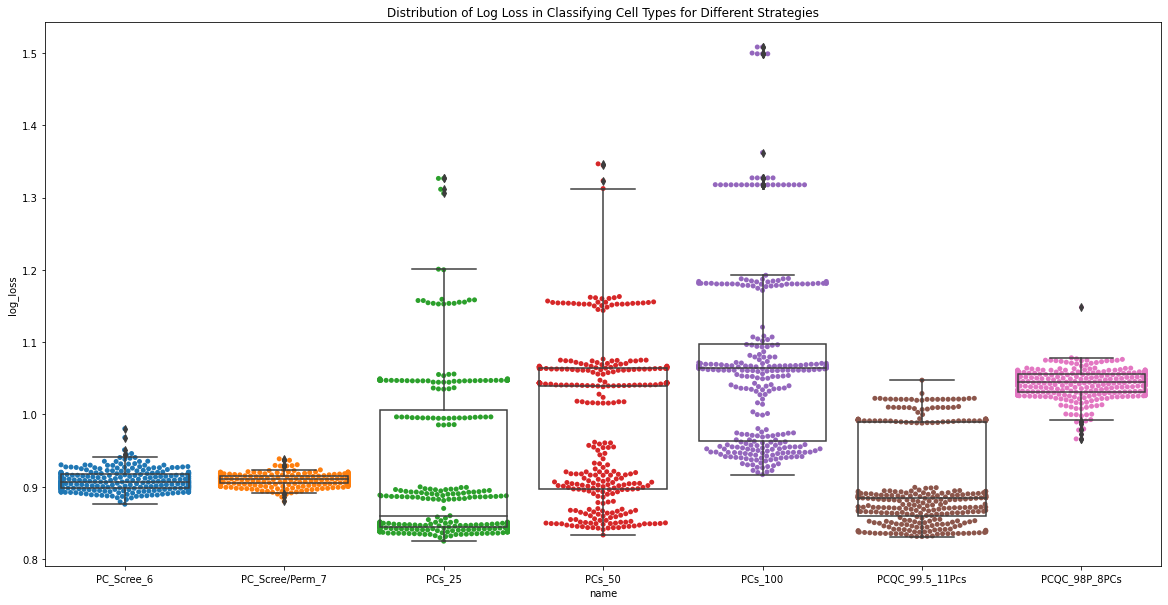

In [42]:
plt.rcParams['figure.figsize'] = [20, 10]
sns.boxplot('name', 'log_loss', data=df_stats, boxprops={'facecolor':'None'})
sns.swarmplot('name', 'log_loss', data=df_stats, zorder=.5)
plt.title('Distribution of Log Loss in Classifying Cell Types for Different Strategies')
plot_dictionary['Log Loss'] = plt.gca().get_figure()

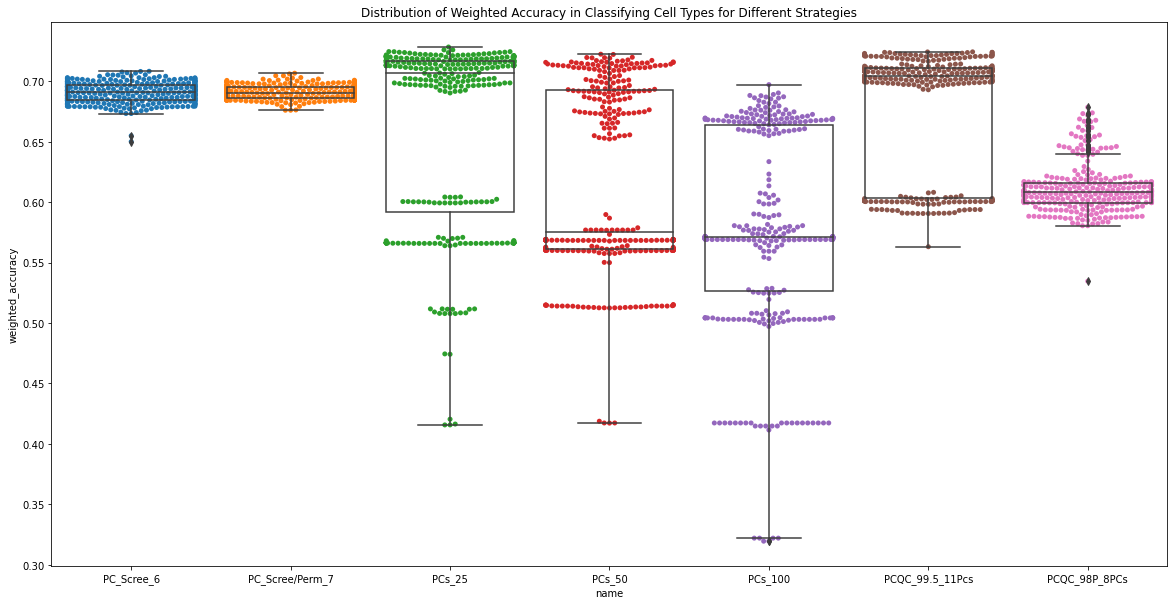

In [43]:
plt.rcParams['figure.figsize'] = [20, 10]
sns.boxplot('name', 'weighted_accuracy', data=df_stats, boxprops={'facecolor':'None'})
sns.swarmplot('name', 'weighted_accuracy', data=df_stats, zorder=.5)
plt.title('Distribution of Weighted Accuracy in Classifying Cell Types for Different Strategies')
plot_dictionary['WeightedAccuracy'] = plt.gca().get_figure()

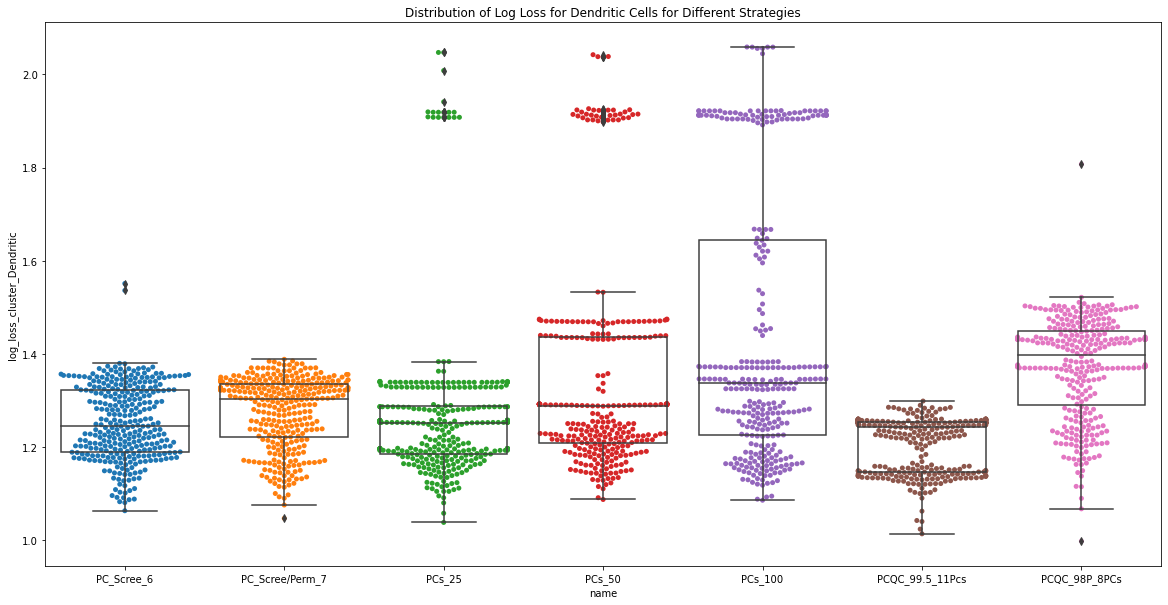

In [44]:
plt.rcParams['figure.figsize'] = [20, 10]
sns.boxplot('name', 'log_loss_cluster_Dendritic', data=df_stats, boxprops={'facecolor':'None'})
sns.swarmplot('name', 'log_loss_cluster_Dendritic', data=df_stats, zorder=.5)
plt.title('Distribution of Log Loss for Dendritic Cells for Different Strategies')
plot_dictionary['Log Loss Dendritic'] = plt.gca().get_figure()

In [39]:
pd.options.display.max_columns = 200

In [40]:
#CD_14+, Dendritic
df_stats.groupby('name').describe()

resolution                                         log_loss  \
                     count mean       std  min  25%  50%  75%  max    count   
name                                                                          
PCQC_98P_8PCs        320.0  1.0  0.447914  0.4  0.7  1.0  1.3  1.6    320.0   
PCQC_99.5_11Pcs      320.0  1.0  0.447914  0.4  0.7  1.0  1.3  1.6    320.0   
PC_Scree/Perm_7      320.0  1.0  0.447914  0.4  0.7  1.0  1.3  1.6    320.0   
PC_Scree_6           320.0  1.0  0.447914  0.4  0.7  1.0  1.3  1.6    320.0   
PCs_100              320.0  1.0  0.447914  0.4  0.7  1.0  1.3  1.6    320.0   
PCs_25               320.0  1.0  0.447914  0.4  0.7  1.0  1.3  1.6    320.0   
PCs_50               320.0  1.0  0.447914  0.4  0.7  1.0  1.3  1.6    320.0   

                                                                             \
                     mean       std       min       25%       50%       75%   
name                                                                          
PCQC_98P_8PCs    1.042263  0.020131  0.965495  1.030577  1.045414  1.055806   
PCQC_99.5_11Pcs  0.904453  0.063468  0.830927  0.859724  0.883700  0.989734   
PC_Scree/Perm_7  0.909811  0.007875  0.879655  0.904586  0.910985  0.914179   
PC_Scree_6       0.908278  0.013769  0.875701  0.898621  0.906254  0.916861   
PCs_100          1.071283  0.121306  0.916606  0.962574  1.063490  1.097960   
PCs_25           0.921618  0.106704  0.824565  0.843504  0.858901  1.006145   
PCs_50           0.990002  0.105789  0.833107  0.896787  1.038725  1.063495   

                             aps                                          \
                      max  count      mean       std       min       25%   
name                                                                       
PCQC_98P_8PCs    1.148209  320.0  0.515118  0.015579  0.447651  0.503899   
PCQC_99.5_11Pcs  1.047348  320.0  0.582278  0.046599  0.455712  0.515942   
PC_Scree/Perm_7  0.938519  320.0  0.592503  0.011325  0.574546  0.583190   
PC_Scree_6       0.980136  320.0  0.595986  0.016837  0.537422  0.582050   
PCs_100          1.508272  320.0  0.478211  0.060767  0.280921  0.435306   
PCs_25           1.326458  320.0  0.562845  0.067307  0.337998  0.500595   
PCs_50           1.346637  320.0  0.513978  0.062447  0.339438  0.471624   

                                              weighted_accuracy            \
                      50%       75%       max             count      mean   
name                                                                        
PCQC_98P_8PCs    0.513726  0.528018  0.551162             320.0  0.610881   
PCQC_99.5_11Pcs  0.603260  0.617947  0.627614             320.0  0.678429   
PC_Scree/Perm_7  0.590633  0.600940  0.627243             320.0  0.690748   
PC_Scree_6       0.597558  0.611552  0.629632             320.0  0.690578   
PCs_100          0.480491  0.535691  0.572598             320.0  0.576665   
PCs_25           0.601127  0.610261  0.625586             320.0  0.663043   
PCs_50           0.479605  0.578361  0.616442             320.0  0.617957   

                                                                             \
                      std       min       25%       50%       75%       max   
name                                                                          
PCQC_98P_8PCs    0.019546  0.534601  0.599589  0.607961  0.615809  0.678494   
PCQC_99.5_11Pcs  0.050122  0.563098  0.603385  0.704091  0.710527  0.724263   
PC_Scree/Perm_7  0.005664  0.675984  0.686245  0.690204  0.694937  0.706611   
PC_Scree_6       0.008472  0.650023  0.684387  0.690732  0.697028  0.708205   
PCs_100          0.082377  0.319554  0.526746  0.571036  0.664010  0.697148   
PCs_25           0.075507  0.415718  0.592206  0.706400  0.716917  0.728280   
PCs_50           0.075212  0.417212  0.561025  0.575026  0.693080  0.722339   

                log_loss_cluster_B Cells                                \
                                   co

In [45]:
with PdfPages(output_plots) as pdf:
    for key in plot_dictionary.keys():
        pdf.savefig(plot_dictionary[key])

### End

### Try PCQC/Kruskal

In [32]:
reduced_matrix = reduced_matrix[:,[0,1,2,3,4,5,6,7,10]]

In [33]:
adata_pcqc = sc.AnnData(X = reduced_matrix)


In [34]:
df_stats = data_sim(adata_pcqc, 'PCQC_Kruskal_9.15', df_stats, ground_truth, 
                    random_state_start = 0, n_pcs = 0, use_rep = 'X')

In [84]:
df_stats.groupby('name').median()

,resolution,log_loss,aps,weighted_accuracy,log_loss_cluster_B Cells,log_loss_cluster_CD14+,log_loss_cluster_CD4 T,log_loss_cluster_CD8,log_loss_cluster_Dendritic,log_loss_cluster_FCGR3A Monocytes,log_loss_cluster_Megakaryocytes,log_loss_cluster_NK,log_loss_cluster_Other
name,,,,,,,,,,,,,
PCQC_10,1.0,0.883887,0.603218,0.703175,0.551945,0.726936,1.366195,1.364829,1.239386,0.425917,0.365504,0.466037,1.502665
PCQC_15,1.0,0.883569,0.600456,0.703779,0.560359,0.705206,1.355048,1.324690,1.253862,0.421348,0.376242,0.476412,1.489094
PCQC_20,1.0,0.890341,0.594507,0.697261,0.561396,0.721772,1.377375,1.327933,1.278927,0.431110,0.400249,0.494665,1.500260
PCQC_Kruskal_9.15,1.0,0.881521,0.604218,0.704434,0.553191,0.737694,1.351168,1.331984,1.205648,0.416546,0.432280,0.424099,1.492179
PC_Perm_18,1.0,0.889379,0.598771,0.702790,0.559525,0.710054,1.368175,1.323522,1.241485,0.467280,0.379825,0.486516,1.491706
PC_Perm_6,1.0,0.906254,0.597558,0.690732,0.561239,0.782916,1.365629,1.378319,1.244619,0.389172,0.431882,0.514136,1.504682
PC_Perm_All_Sig,1.0,1.063490,0.480491,0.571036,0.600761,1.023959,1.409359,1.589818,1.336994,0.895936,0.512077,0.669307,1.575820
PC_Scree_7,1.0,0.910985,0.590633,0.690204,0.554241,0.766323,1.371908,1.352762,1.302374,0.382149,0.440677,0.530151,1.522491
PC_Scree_8,1.0,0.907243,0.592796,0.692306,0.551299,0.761071,1.361673,1.349174,1.313116,0.388420,0.435629,0.522987,1.503727


In [38]:
ground_truth['leiden'].value_counts()

CD4 T               768
CD14+               545
Other               444
CD8                 292
B Cells             255
NK                  159
FCGR3A Monocytes    106
Dendritic            55
Megakaryocytes       14
Name: leiden, dtype: int64

In [77]:
ground_truth['leiden'].value_counts()

CD4 T               768
CD14+               545
Other               444
CD8                 292
B Cells             255
NK                  159
FCGR3A Monocytes    106
Dendritic            55
Megakaryocytes       14
Name: leiden, dtype: int64

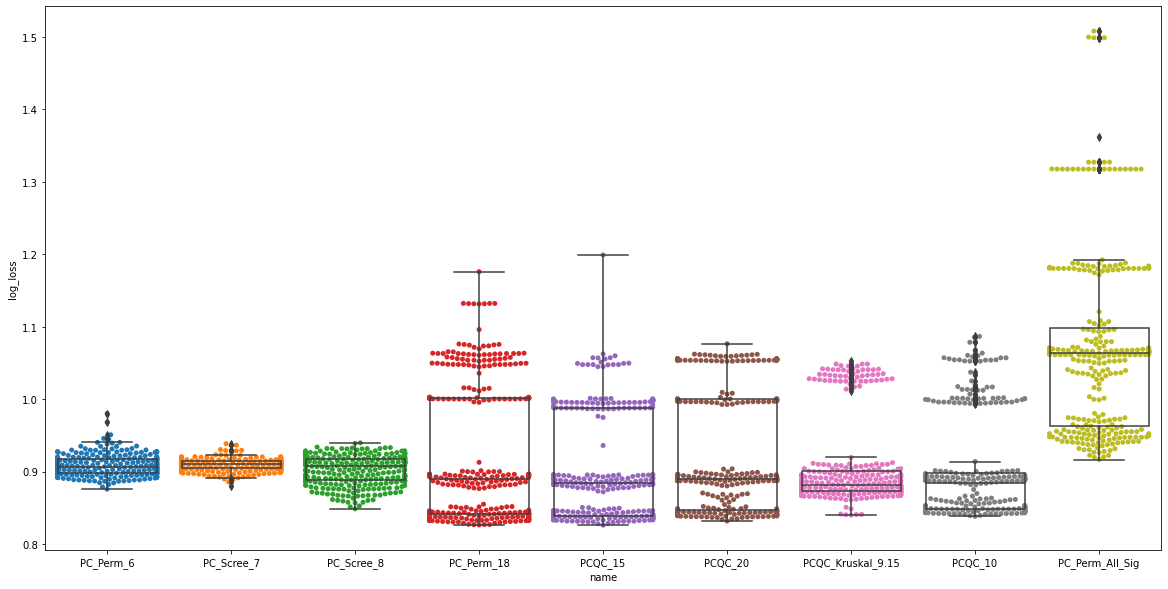

In [85]:
plt.rcParams['figure.figsize'] = [20, 10]
sns.boxplot('name', 'log_loss', data=df_stats, boxprops={'facecolor':'None'})
sns.swarmplot('name', 'log_loss', data=df_stats, zorder=.5)

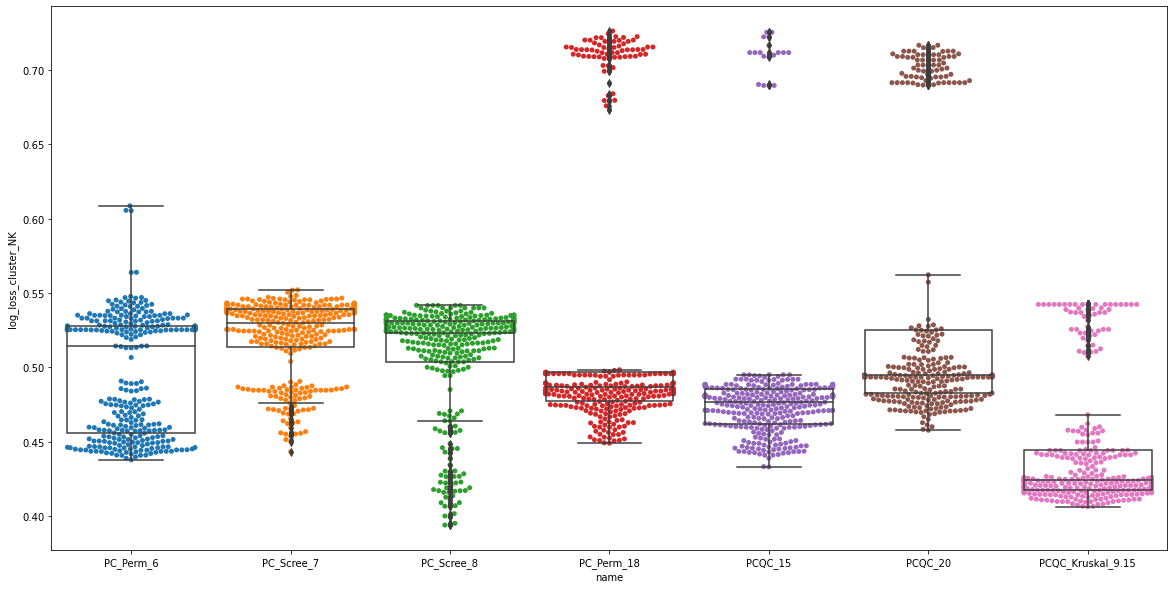

In [72]:
sns.boxplot('name', 'log_loss_cluster_NK', data=df_stats, boxprops={'facecolor':'None'})
sns.swarmplot('name', 'log_loss_cluster_NK', data=df_stats, zorder=.5)

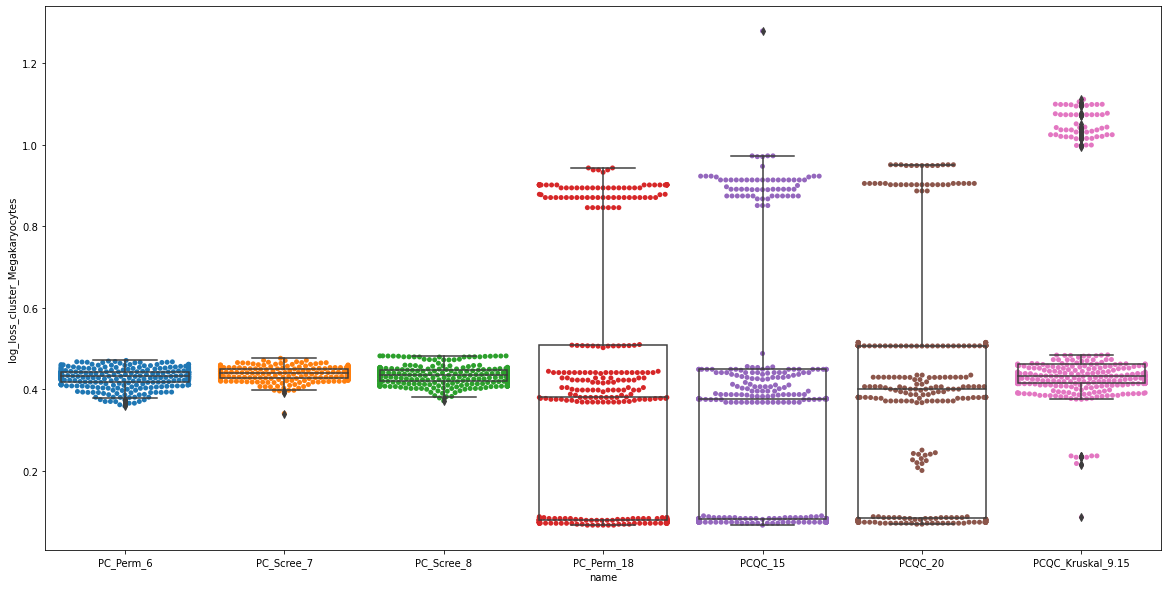

In [73]:
sns.boxplot('name', 'log_loss_cluster_Megakaryocytes', data=df_stats, boxprops={'facecolor':'None'})
sns.swarmplot('name', 'log_loss_cluster_Megakaryocytes', data=df_stats, zorder=.5)

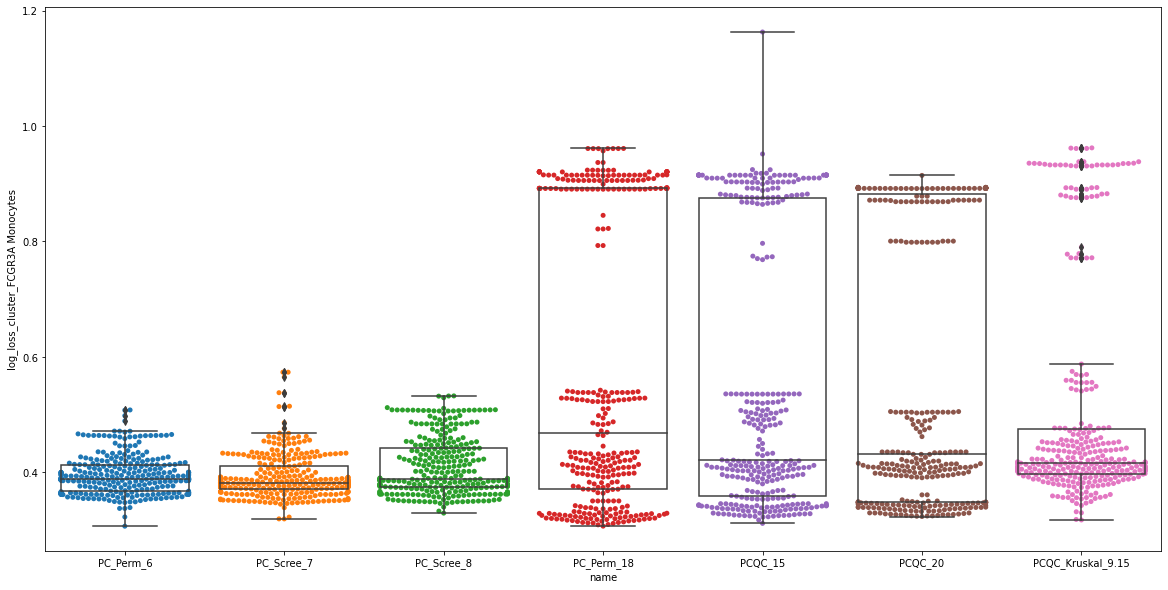

In [74]:
sns.boxplot('name', 'log_loss_cluster_FCGR3A Monocytes', data=df_stats, boxprops={'facecolor':'None'})
sns.swarmplot('name', 'log_loss_cluster_FCGR3A Monocytes', data=df_stats, zorder=.5)

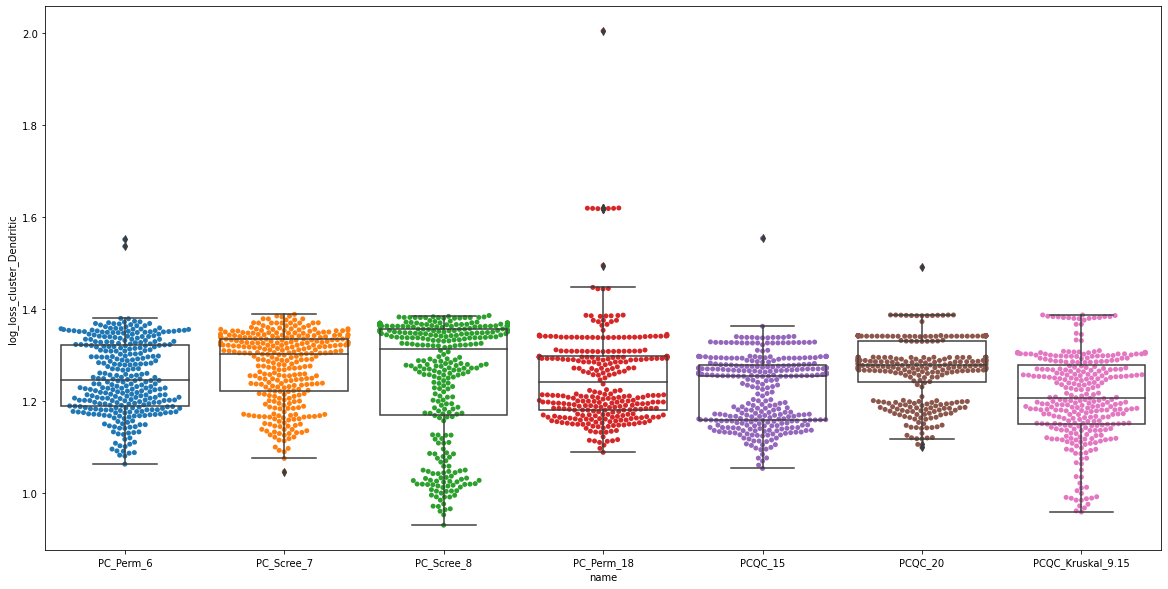

In [76]:
sns.boxplot('name', 'log_loss_cluster_Dendritic', data=df_stats, boxprops={'facecolor':'None'})
sns.swarmplot('name', 'log_loss_cluster_Dendritic', data=df_stats, zorder=.5)

In [49]:
ground_truth['leiden']

0             CD8
1           CD4 T
2           CD4 T
3           CD14+
4              NK
          ...    
2633    Dendritic
2634        CD4 T
2635      B Cells
2636      B Cells
2637        Other
Name: leiden, Length: 2638, dtype: object

In [52]:
df = pd.DataFrame(adata.obs['leiden'].values, columns = ['unsupervised'])
df = pd.concat([df,pd.DataFrame(ground_truth['leiden'].values)], axis = 1)

In [54]:
pd.crosstab(df[0],df['unsupervised'])

unsupervised,0,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,,
B Cells,4,235,4,3,0,4,2,0,0,3,0,0,0
CD14+,433,5,4,3,2,3,3,80,0,2,0,7,3
CD4 T,0,51,164,71,151,144,92,0,3,55,36,1,0
CD8,1,7,47,151,17,11,14,0,12,13,19,0,0
Dendritic,3,1,6,4,4,2,0,1,2,0,1,31,0
FCGR3A Monocytes,1,0,0,0,0,0,0,103,0,0,2,0,0
Megakaryocytes,0,0,0,0,0,0,0,0,0,0,0,0,14
NK,0,0,0,25,1,0,0,0,133,0,0,0,0
Other,1,41,98,49,82,42,77,1,5,24,23,1,0


### Try Kruskal (smaller data subsets)